# Entrega 2, Grupo 02 - Aprendizaje Bayesiano

- Santiago Alaniz,  5082647-6, santiago.alaniz@fing.edu.uy
- Bruno De Simone,  4914555-0, bruno.de.simone@fing.edu.uy
- María Usuca,      4891124-3, maria.usuca@fing.edu.uy

## Objetivo

Implementar un algoritmo de predicción de palabras utilizando Naive Bayes. El modelo se entrenará con datos de conversaciones de WhatsApp y se probará en un simulador de cliente. El algoritmo debe ser capaz de recomendar palabras basadas en las últimas `N` palabras ingresadas en una frase. `N` es un **hiperparámetro** a incorporar en el modelo. Además, el modelo se re-entrenará al finalizar cada frase para adaptarse a nueva evidencia. 
<br>

La implementación debe ser eficiente en términos de uso de CPU, utilizando las estructuras de datos más adecuadas en Python.

## Diseño

### Carga del dump de conversaciones en un grupo de WhatsApp y Particionamiento

WhatsApp permite exportar las conversaciones de un grupo en un archivo de texto plano. Cada entrada del dump tiene el siguiente formato:

```
  [dd/mm/aaaa hh:mm:ss] <nombre | telefono>: <mensaje>
```

Nos valemos del módulo `src.regex` para definir la [regex](https://es.wikipedia.org/wiki/Expresi%C3%B3n_regular) que detecta el patrón. Esta expresión regular captura el contenido de cada entrada del dump en dos grupos:

- `metadata`: metadata generada por el dump de WhatsApp. No nos interesa recuperarla.

- `message`:  Mensajes de texto escritos por los usuarios del grupo. Se utiliza para entrenar el modelo.

Particionamos los datos en tres conjuntos con `train_test_split` de `sklearn`:

  - `train` para entrenar el modelo.

  - `devel` para evaluar el modelo.

  - `test` para evaluar el modelo final.

  *Nota*:

  Observamos una publicación en el EVA del curso sobre mutliples formatos dependiendo de IOS/Android. Nostros utilizamos el formato de Android.

In [2]:
import re
import random
from sklearn.model_selection import train_test_split
from src.whatsapp_regex import LOG_ENTRY_PATTERN as PATTERN

SEED = 42069
random.seed(SEED)

FILE_PATH = './assets/chat.txt'

with open(FILE_PATH, 'r', encoding='utf-8') as f: data = f.read()
matches = re.findall(PATTERN, data)
data = [ match[1] for match in matches ]

TEST_SIZE   = 0.5
DEVEL_SIZE  = 0.5

train, test = train_test_split(data, test_size= TEST_SIZE, random_state= SEED)
test, devel = train_test_split(test, test_size= DEVEL_SIZE, random_state= SEED)

print(f'\
Cantidad de mensajes: {len(data)}\n\
Train, Devel, Test: ({len(train)}, {len(devel)}, {len(test)})\n\
')

train[:10]

Cantidad de mensajes: 5446
Train, Devel, Test: (2723, 1362, 1361)



['@59898515829 Fernando, no encontré a Fabián acá en el grupo para meterle un @ y avisarle que estamos los 4 para las 20.',
 'Hoy jue 18h  5ta/6ta C1\n1 Marco\n2 Fernando\n3 \n4',
 'Buen regreso Fede!',
 'Hola, si escríbanle mañana a Fer por las dudas que tenga a alguien en espera\nAbrazo',
 '16 cancha 1',
 'La cancha 2 a las 18h queda reservada hasta 12:30 aprox, luego confirmo si se ocupa o queda libre',
 'Si sale alguno a las 20 estoy !',
 'Fer, ya somos 4 para las 18, ahí reserve en la app',
 'Hoy 19h cat 6 ta\n1-ramiro\n2- Pablo \n3- nico\n4-',
 'Jajaja banco']

### Preprocesamiento de datos

Para nuestro algoritmo de predicción de palabras optamos aplicar los siguientes pasos de preprocesamiento:

- **Tokenización ordenada**: Para que el algoritmo pueda identificar correctamente las palabras y su posición en la oración, es necesario dividir la oración en [tokens](https://es.wikipedia.org/wiki/Token).

- **Conversión a minúsculas**: Para que el algoritmo no trate las palabras como diferentes solo debido a las diferencias de mayúsculas y minúsculas.

- **Eliminación de caracteres especiales, numéricos, emojis**: Estos componentes léxicos y semánticos no aportan información relevante para el modelo que busca sugerir palabras.

- **Relajar tildes con [unidecode](https://pypi.org/project/Unidecode/)**: Para que el modelo no distinga palabras con tildes de palabras sin tildes. Teniendo en cuenta que en los mensajes de WhatsApp es muy común que se omitan las tildes.

- **Validación de palabras en español**: Construimos un conjunto de palabras en español a partir de dos fuentes: `es_words.txt` y `nltk.corpus.stopwords('spanish')`. Esta colección se utiliza para filtrar palabras que no pertenecen al idioma.

Construimos la clase `src.G02Preprocessor` para encapsular la lógica de preprocesamiento. Esta clase se encarga de aplicar los pasos de preprocesamiento mencionados anteriormente. Además, se encarga de almacenar las palabras en un diccionario para facilitar el acceso a las mismas.

*Nota*:

En el último punto asumimos que el conjunto `es_words.txt + nltk.corpus.stopwords('spanish')` es representativo del lenguaje. Teniendo en cuenta la extensión de este conjunto (`~600k palabras`), el hecho de que una palabra en español no pertenezca a este conjunto es un escenario marginal.

In [3]:
from src.preprocessing import G02Preprocessor


preprocessor = G02Preprocessor()
ejemplo = random.choice(train)

print(f'\
Prepocesador:\n\
    Palabras del diccionario: {len(preprocessor.V_SPA)} \n\
    Ejemplo:\n      {ejemplo}\n\
    Ejemplo preprocesado: {preprocessor.apply([ejemplo])}')


Prepocesador:
    Palabras del diccionario: 635044 
    Ejemplo:
      Tremenda jornada
    Ejemplo preprocesado: [['tremenda', 'jornada']]


### Algoritmo

El algoritmo a implementar es un [clasificador bayesiano naive](https://es.wikipedia.org/wiki/Clasificador_bayesiano_ingenuo). Con la incorporación de un meta-parámetro `N`, que indica la cantidad de palabras anteriores a considerar para la predicción de la siguiente palabra. 

En la letra del laboratorio se menciona que este algoritmo es intensivo en CPU, es parte de la consigna del laboratorio implementar el algoritmo de la manera más eficiente posible.

Objetivos a cumplir:

- **Módulo auxiliar `naive_bayes_utils.py`**: Define las estructuras de datos auxiliares y operaciones matemáticas necesarias para el funcionamiento de un clasificador bayesiano, debemos definir funciones que las actualicen y consulten. Estas funciones se encuentran definidas en el módulo `naive_bayes_utils.py`

- **Clase `G02NaiveBayesClassifier`**: Una vez implementadas las estructuras de datos, debemos implementar la clase `G02NaiveBayesClassifier` que encapsula el algoritmo de clasificación y mantiene todo el aparato auxiliar encapsulado bajo la misma clase. Esta clase está definida en el módulo `bayesian_learning.py`.

#### Módulo auxiliar `naive_bayes_utils.py`

El módulo `naive_bayes_utils.py` encapsula las estructuras de datos y los algoritmos auxiliares necesarios para el funcionamiento del clasificador bayesiano naive. 

Estas estructuras de datos fueron definidas en el punto anterior y fueron implementadas en el módulo `naive_bayes_utils.py` de la siguiente manera:

- `build(data, N)`: Genera estructuras auxiliares para realizar el cálculo de probabilidades. Recibe como parámetro el conjunto de entrenamiento y el meta-parámetro `N`. Devuelve las siguientes estructuras:

    - `N_OF_WORDS`: Cantidad de palabras en el conjunto de entrenamiento.
    
    - `F_h`: Frecuencia de cada hipótesis (palabra) en el conjunto de entrenamiento.

    - `F_hD`: Frecuencia de cada evidencia (palabra anterior) dado una hipótesis (palabra) en el conjunto de entrenamiento. `F_hD` es un diccionario de diccionarios y es afectado por el meta-parámetro `N`, ya que la cantidad de evidencias a considerar depende de `N`. Por ejemplo, si `N=4` y la hipótesis es `h`, `F_hD[h]` es un diccionario que contiene la frecuencia de cada combinación de 4 palabras anteriores a `h` en el conjunto de entrenamiento.

- `p_h(h, V, F_h, data)`: Calcula una probabilidad ajustada para la ocurrencia de una palabra específica (`h`) en el conjunto de datos.
- `p_hD(d, h, V_SPA, F_h, F_hD, m=1)`: Calcula la probabilidad condicional de que una palabra (`d`) preceda a (`h`).

*Nota*:

El enfoque de `build` es greedy. Si la frase no tiene el largo de palabras necesario toma hasta donde puede. Por ejemplo, si `N=4` y la frase es `['hola', 'como', 'estas']`, se toma `['hola', 'como']` como evidencia para `['estas']`, `['hola']` como evidencia para `['como']` y así sucesivamente.

En la firma de `p_h` abusamos de la notación, en realidad estamos calculando la métrica **tf-idf**. Consideramos que esta métrica es mucho más significativa que simplemente la frecuencia de la hipótesis en el conjunto de entrenamiento. [TF-IDF](https://es.wikipedia.org/wiki/Tf-idf) es una métrica comúnmente usada en el procesamiento del lenguaje natural para valorar la importancia de una palabra en un corpus en relación con su frecuencia en documentos específicos. En este caso particular, si una palabra tiene una frecuencia alta y es muy común a lo largo de todo el corpus, es decir, aparece en muchas frases, entonces no es muy significativa para la predicción. Por el contrario, si una palabra tiene una frecuencia alta y aparece en pocas frases, entonces es muy significativa para la predicción. Es una forma elegante de reducir la inferencia de las [stopwords](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa) en el modelo sin tener que filtrarlas.

En la implementación de `p_hD` se utiliza un m-estimador para evitar que la probabilidad condicional sea cero. Asumimos equiprobabilidad a priori de la evidencia, siendo esta `1/len(V_SPA)` donde `V_SPA` es el vocabulario de palabras en español que utilizamos en el preprocesamiento de los datos.

En lo que a uso de memoria refiere, consideramos más apropiado guardar las frecuencias de las hipótesis y las evidencias en un diccionario de diccionarios, en lugar de una matriz. Esto se debe a que la cantidad de hipótesis y evidencias es muy grande, y la cantidad de combinaciones de hipótesis y evidencias es mucho mayor. Por lo tanto, la matriz de frecuencias sería muy dispersa y ocuparía mucha memoria.

En lo que uso de ciclos del cpu refiere, creemos que es más eficiente mantener las frecuencias y no las probabilidades, dado que a la hora de aprender una nueva frase, es menos costoso actualizar lo primero que lo segundo. La fórmula de `h_map` se hace 'on the fly' y no se guarda en memoria.

In [4]:
from src.naive_bayes_utils import *

_train = preprocessor.apply(train)

N_OF_WORDS, F_h, F_hD = build(_train, N=1)

print(f'\
Estructuras de datos\n\
    Cantidad de palabras en train:    {N_OF_WORDS}\n\
    Frecuencia de h:                  {(F_h)}\n\
    Frecuencia condicional D dado h:  {(F_hD)}\n')

h_ex = random.choice(list(F_h.keys()))
d_ex = random.choice(list(preprocessor.V_SPA))

print(f'\
Probabilidades\n\
    h_ex: {h_ex}\n\
    d_ex: {d_ex}\n\
    p_h(h_ex) (td-idf): {p_h(h_ex, N_OF_WORDS, F_h, _train)}\n\
    p_hD(d_ex)(h_ex): {p_hD(d_ex, h_ex, preprocessor.V_SPA, F_h, F_hD)}')


Estructuras de datos
    Cantidad de palabras en train:    11858
    Frecuencia de h:                  Counter({'hoy': 615, 'para': 492, 'a': 456, 'las': 325, 'horarios': 298, 'disponibles': 296, 'si': 289, 'la': 270, 'se': 263, 'de': 198, 'gracias': 195, 'que': 186, 'no': 157, 'cancha': 154, 'buenas': 153, 'y': 146, 'me': 146, 'en': 124, 'este': 115, 'por': 113, 'el': 111, 'estoy': 98, 'una': 87, 'mensaje': 85, 'ya': 82, 'elimino': 76, 'libero': 76, 'miercoles': 73, 'esta': 70, 'bien': 70, 'falta': 68, 'yo': 67, 'fer': 66, 'diego': 66, 'un': 63, 'pronto': 63, 'dia': 62, 'uno': 62, 'nos': 61, 'hay': 60, 'es': 58, 'hora': 58, 'te': 56, 'viernes': 56, 'jorge': 54, 'lunes': 53, 'los': 52, 'con': 52, 'jueves': 48, 'martes': 47, 'buen': 46, 'juan': 46, 'adrian': 45, 'o': 43, 'multimedia': 43, 'omitido': 43, 'mas': 42, 'reservada': 41, 'manana': 39, 'sale': 39, 'completo': 39, 'ahi': 37, 'vemos': 37, 'alguno': 36, 'bueno': 36, 'horas': 35, 'jugar': 34, 'como': 33, 'arriba': 32, 'partido': 31

#### Clase `G02NaiveBayesClassifier`

La clase `G02NaiveBayesClassifier` es nuestra implementación del algoritmo de clasificación Naive Bayes con un enfoque en el procesamiento del lenguaje natural. Estos son los métodos principales de la clase:

- **__init__(self, data, N=1, M=1)** Inicializa el clasificador:

    - `data`: El conjunto de datos sobre el cual se construirá el modelo.
    
    - `N`: El tamaño del contexto para el modelo.
    
    - `M`: Un parámetro para suavizado.
    
    Se realiza la preprocesamiento de los datos y se construyen las estadísticas (frecuencias de términos y pares de términos) utilizando la función `build`.

- **predict(self, sentence)** Realiza una predicción para una oración dada tomando en cuenta las N-últimas palabras:

    - `sentence`: La oración para la cual se realizará la predicción.

    Calcula la `h_map` para las N-últimas palabras de `sentence`. Si `h_map` es alguna de las N-últimas palabras de `sentence`, se itera hasta encontrar la palabra más probable que no sea alguna de las N-últimas palabras de `sentence`.

- **update(self, new_sentence)** Actualiza el modelo con una nueva oración:

    - `new_sentence`: La nueva oración para actualizar el modelo.

    Aplica el mismo preprocesamiento de los datos iniciales a la `new_sentence` y actualiza las estadísticas del modelo (`F_h` y `F_hD`).

- **self.preprocessor**: Instancia de la clase `G02Preprocessor` que encapsula la lógica de preprocesamiento.

- **self.V_SPA**: Vocabulario de palabras en español que utilizamos en el preprocesamiento de los datos.

- **self.N_OF_WORDS, self.F_h, self.F_hD**: Estructuras auxiliares para calcular las probabilidades de las hipótesis.

*Nota*:

La decisión de actualizar el Vocabulario en Español (`V_SPA`) con las palabras de la nueva oración es discutible. Por un lado, es posible que la nueva oración contenga palabras que no pertenecen al idioma español, como también que el usuario escriba palabras del español poco usuales y que estas no estén dentro del compendio del `cess_esp`. 

Por eso, asumimos que el usuario del cliente escribe en español (aunque se tome libertades a la hora de asignar tildes)

El siguiente código provee un benchmarking de la implementación del algoritmo de clasificación bayesiana naive.


In [5]:
from src.bayesian_learning import G02NaiveBayesClassifier
import time

start = time.time()
clf = G02NaiveBayesClassifier(train, N=1)
print(f'[INIT]  Tiempo de ejecución: {time.time() - start:.4f}s')
example = [random.choice(list(preprocessor.V_SPA))]

print(' '.join(example))

start = time.time()
for i in range(2): example.append(clf.predict(example))
print(f'[PREDICT] Tiempo de ejecución: {time.time() - start:.4f}s')

print(f'        V: {clf.N_OF_WORDS} \
    \n          F_h[{example[1]}]: {clf.F_h[example[1]]} \
    \n          F_hD[{example[1]}][{example[0]}]: {clf.F_hD[example[1]][example[0]]} \
    \n          F_h[{example[2]}]: {clf.F_h[example[2]]} \
    \n          F_hD[{example[2]}][{example[1]}]: {clf.F_hD[example[2]][example[1]]}')

start = time.time()

print(' '.join(example))

clf.update(' '.join(example))
print(f'[UPDATE]  Tiempo de ejecución: {time.time() - start:.4f}s')

print(f'        V: {clf.N_OF_WORDS} \
    \n          F_h[{example[1]}]: {clf.F_h[example[1]]} \
    \n          F_hD[{example[1]}][{example[0]}]: {clf.F_hD[example[1]][example[0]]} \
    \n          F_h[{example[2]}]: {clf.F_h[test[2]]} \
    \n          F_hD[{example[2]}][{example[1]}]: {clf.F_hD[example[2]][example[1]]}')

[INIT]  Tiempo de ejecución: 0.3368s
encorvaramos
[PREDICT] Tiempo de ejecución: 0.3404s
        V: 11858     
          F_h[club]: 7     
          F_hD[club][encorvaramos]: 0     
          F_h[debe]: 1     
          F_hD[debe][club]: 1
encorvaramos club debe
[UPDATE]  Tiempo de ejecución: 0.0001s
        V: 11861     
          F_h[club]: 8     
          F_hD[club][encorvaramos]: 1     
          F_h[debe]: 0     
          F_hD[debe][club]: 2


### Evaluación

En cualquier laboratorio o proyecto de investigación, la sección de evaluación es crucial para entender cómo se mide el rendimiento del modelo y qué métricas son relevantes para el problema en cuestión. Sin embargo, la naturaleza planteada en la letra del laboratorio no permite una evaluación cuantitativa del modelo. Por lo tanto, proponemos una evaluación cualitativa del modelo.

Alterando el tamaño de la ventana de palabras `N`  buscamos encontrar un equilibrio entre las siguientes cualidades deseables:

- **Memoria**: El modelo debe ser capaz de sugerir palabras que tengan coherencia con el grupo de Whatsapp de donde se extrajeron los datos.

- **Adaptación**: El modelo debe ser capaz de adaptarse a la nueva evidencia, y mejorar su performance, sugiriendo palabras que tengan coherencia con la sesión de chat que se está simulando.

Vamos a entrenar el modelo con el conjunto de `train`, y probar con el conjunto de `devel` para encontrar el mejor N que maximice la performance del modelo. Asumimos que hay frases en devel que no están en train, por lo tanto, el modelo no las conoce. Y a su vez, hay frases que son muy similares a las conocidas por el modelo. 

Para evaluar la performance del modelo, vamos a utilizar el siguiente criterio:

- Una frase es **correctamente predicha** si el modelo sugiere la ultima palabra de la frase.

- Una frase es **incorrectamente predicha** si el modelo sugiere una palabra que no es la ultima palabra de la frase.

- Para cada frase **incorrectamente predicha** se re-entrena el modelo con la frase en la próxima iteración.

El problema que tiene esto es el siguiente: Sabemos por la seccion anterior que el modelo es intensivo en CPU, con train al 50% del dataset demora `~0.3` segundos en encontrar la `h_map` de una frase tomando `N=1`, este desempeño no hace mas que **empeorar** a medida que aumentamos `N` y el tamaño del dataset. Por lo tanto, no es viable evaluar cada frase de `devel` con el modelo re-entrenado.

Proponemos una solucion estadistica al problema, tomando una muestra de `devel` que garantice un nivel de confianza del 95% y un error del 5%. De esta forma el estimador se expresaria en intervalos de confianza, y no en valores puntuales, pero nos permitiria evaluar el modelo en un tiempo razonable.

Después de aplicar esta tecnica, construimos un `CSV` con los resultados obtenidos.

- `grid_search.csv`: Resultados de la búsqueda con grid search.

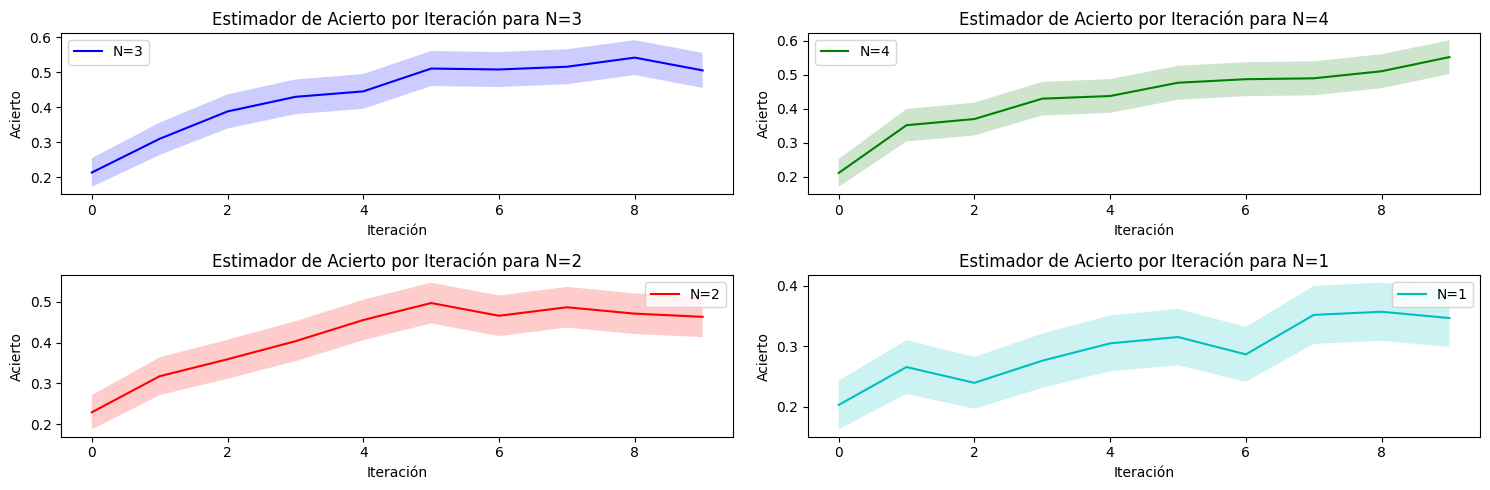

In [6]:
from src.bayesian_learning import G02NaiveBayesClassifier
from src.test_learning import train_and_evaluate
import os, pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt
 
ITERATIONS = 10
Z = 1.96
P = 0.5
E = 0.05
_N = int(Z**2 * P * (1-P) / E**2)

_devel = preprocessor.apply(devel)

def grid_search_to_csv():
    results = pd.DataFrame(columns=['N', 'iteration', 'lower_bound', 'upper_bound'])
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = []
        for N in [1,2,3,4]:
            clf = G02NaiveBayesClassifier(train, N=N)
            future = executor.submit(train_and_evaluate, clf, _N, _devel, ITERATIONS, Z)
            futures.append(future)
            
        for future in concurrent.futures.as_completed(futures):
            rusult = future.result()
            for (N, i, _P_neg, _P_pos) in rusult:
                results.loc[len(results)] = [N, i, _P_neg, _P_pos] 
            
    results.to_csv('assets/grid_search.csv', index=False)         

if not os.path.exists('assets/grid_search.csv'): grid_search_to_csv()

grid_search_csv = 'assets/grid_search.csv'
results = pd.read_csv(grid_search_csv)

colors = ['b', 'g', 'r', 'c']
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
axes = axes.flatten()

for i, n in enumerate(results['N'].unique()):
    ax = axes[i]
    subset = results[results['N'] == n]
    iterations = subset['iteration']
    lower_bounds = subset['lower_bound']
    upper_bounds = subset['upper_bound']
    mean_values = [(lower + upper) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]

    ax.plot(iterations, mean_values, label=f'N={int(n)}', color=colors[i])
    ax.fill_between(iterations, lower_bounds, upper_bounds, alpha=0.2, facecolor=colors[i])

    ax.set_xlabel('Iteración')
    ax.set_ylabel('Acierto')
    ax.set_title(f'Estimador de Acierto por Iteración para N={int(n)}')
    ax.legend()

plt.tight_layout()
plt.show()

### Definición de nuestro modelo final.

La evaluacion arroja que el mejor clasificador es el que tiene `N=4`, pero por un margen estrecho dado que los intervalos de confianza se superponen, este es un costo que asumimos a la hora de evaluar rapidamente los modelos. Por lo tanto, decidimos tambien quedarnos con el modelo que tiene `N=3`.

Para evaluar nuestro modelo final, vamos aplicar la misma tecnica que en la seccion anterior, pero esta vez con el conjunto de `test` y con `N=3` y `N=4`.

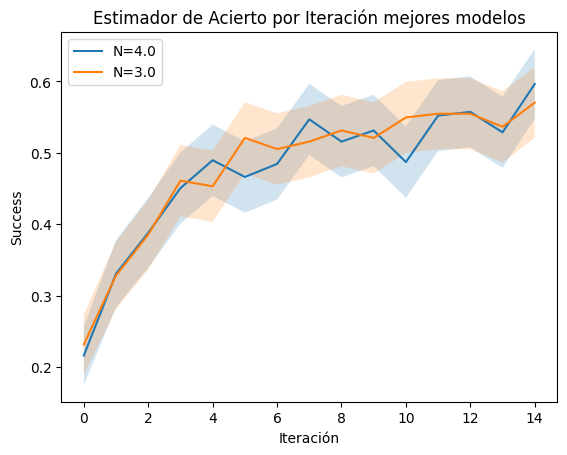

In [7]:
from src.bayesian_learning import G02NaiveBayesClassifier
from src.test_learning import train_and_evaluate
import os, pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt

meta_params_grid = {
    'N': [3,4]
}

_test = preprocessor.apply(test) 
ITERATIONS = 15
Z = 1.96
P = 0.5
E = 0.05
_N = int(Z**2 * P * (1-P) / E**2)

def grid_search_to_csv():
    results = pd.DataFrame(columns=['N', 'iteration', 'lower_bound', 'upper_bound'])
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = []
        for N in meta_params_grid['N']:
            clf = G02NaiveBayesClassifier(train, N=N)
            future = executor.submit(train_and_evaluate, clf, _N, _test, ITERATIONS, Z)
            futures.append(future)
            
        for future in concurrent.futures.as_completed(futures):
            rusult = future.result()
            for (N, i, _P_neg, _P_pos) in rusult:
                results.loc[len(results)] = [N, i, _P_neg, _P_pos] 
            
    results.to_csv('assets/grid_search_N34.csv', index=False)         

if not os.path.exists('assets/grid_search_N34.csv'): grid_search_to_csv()

grid_search_csv = 'assets/grid_search_N34.csv'

results = pd.read_csv(grid_search_csv)

fig, ax = plt.subplots()

for n in results['N'].unique():
    subset = results[results['N'] == n]
    iterations = subset['iteration']
    lower_bounds = subset['lower_bound']
    upper_bounds = subset['upper_bound']
    mean_values = [(lower + upper) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]
    
    ax.plot(iterations, mean_values, label=f'N={n}')  
    ax.fill_between(iterations, lower_bounds, upper_bounds, alpha=0.2)  


ax.set_xlabel('Iteración')
ax.set_ylabel('Success')
ax.set_title('Estimador de Acierto por Iteración mejores modelos')
ax.legend()

plt.show()

## Experimentación

### Simulador de cliente.

El experimento consiste en evaluar los distintos hiper-parámetros del modelo.

El siguiente script permite simular el comportamiento de un cliente que escribe frases, fue proporcionado por el cuerpo docente. Es de utilidad para experimentar con modelo, ya que permite ingresar frases y ver las sugerencias que el modelo realiza.

**Nota:**

El comportamiento del siguiente script en `VSCode` es diferente al comportamiento en la terminal. En VSCode, el script omite entradas, se desfasa y hace que el análisis de los resultados sea difícil. Por lo tanto, recomendamos ejecutar el script en la terminal. (`client.py`)

Otra cosa que vale la mencionar, es que a diferencia de la evaluacion y definicion del modelo final, el clasificador de este script utiliza todo el dataset, y no solo el conjunto de `train`. Esto se debe a que el objetivo de este script es puramente experimental y sirve para que el usuario pueda interactuar con el mismo.

In [ ]:
from src.bayesian_learning import G02NaiveBayesClassifier
from src.whatsapp_regex import LOG_ENTRY_PATTERN
import re

def data():
  FILE_PATH = './assets/chat.txt'
  PATTERN = LOG_ENTRY_PATTERN

  with open(FILE_PATH, 'r', encoding='utf-8') as file:
    data = file.read()

  matches = re.findall(PATTERN, data)
  data = [ match[1] for match in matches ]

  return data

def main():
  N = 3
  M = 1

  clf = G02NaiveBayesClassifier(data(), N=N, M=M)

  frase = []
  palabra_sugerida = ""

  print("Ingrese la frase dando ENTER luego de \x1b[3mcada palabra\x1b[0m.")
  print("Ingrese sólo ENTER para aceptar la recomendación sugerida, o escriba la siguiente palabra y de ENTER")
  print("Ingrese '.' para comenzar con una frase nueva.")
  print("Ingrese '..' para terminar el proceso.")

  while 1:
    palabra = input(">> ")

    if palabra == "..": break

    elif palabra == ".":
      print("----- Comenzando frase nueva -----")
      print(clf.update(" ".join(frase)))

      frase = []

    elif palabra == "": # acepta última palabra sugerida
      frase.append(palabra_sugerida)

    else: # escribió una palabra
      frase.append(palabra)

    if frase:
      frase_propuesta = frase.copy()
      palabra_sugerida = clf.predict(frase)
      frase_propuesta.append("\x1b[3m"+ palabra_sugerida +"\x1b[0m")

      print(" ".join(frase_propuesta))
  return 0

if __name__ == "__main__":
  main()


## Conclusión


A lo largo de este laboratorio, implementamos un algoritmo de clasificación bayesiana naive para la predicción de palabras en el contexto de una conversación de WhatsApp. Nos parecio realmente sorprendente como un algoritmo que es en escencia tan simple, puede tener un rendimiento tan bueno a la hora de realizar predicciones, eso teniendo en cuenta que no aplica reglas semanticas ni de contexto, simplemente se basa en la frecuencia de las palabras en el conjunto de entrenamiento.

Tambien este laboratorio nos permitio explorar una evaluacion por afuera de las metricas tradicionales de clasificacion, como lo son la precision, el recall y el f1-score. En este caso, la evaluacion se baso en la capacidad de lo que nostros entendemos como "adaptacion" del modelo a la nueva evidencia. El hecho de poder definir metricas propias y confirmar/rechazar hipotesis en base a ellas, es altamente didactico y nos permite entender mejor el problema que estamos tratando de resolver.

### Sobre los resultados obtenidos.

Los mejores resultados del modelo se obtienen para los dos valores mas altos de `N`, `N=3` y `N=4`. Esto se debe a que el modelo tiene mas contexto/combinaciones de palabras para inferir la siguiente y por lo tanto mayor probabilidad de exito. Sin embargo, aqui hay una observacion sutil que vale la pena discutir. 

Todo este rendimiento teorico es bajo el supuesto del grupo de wpp que nosotros utilizamos para entrenar el modelo. 

Si el modelo se utilizara en otro grupo de wpp, donde por ejemplo, hay pocos mensajes superiores a 3, 4 palabras, dada la naturaleza greedy de nuestro algoritmo de construccion, seria totalmente irrelevante utilizar `N=3` o `N=4`, ya que el modelo no tendria suficiente evidencia para inferir la siguiente palabra. Equivaldrian a un modelo de N inferior.

Podemos afirmar que el modelo es penalizado si el N no acompaña la naturaleza del grupo de wpp. Esto en un contexto de evaluacion es problematico sobre todo considerando que `test` es una caja negra para nosotros.

### Posibles mejoras

Algunas mejoras que se podrian hacer al modelo son:

- **Incorporar el m-estimador como metaparametro** : De la misma forma que definimos un `N` podriamos utilizar `M` como el numero de sobremuestras que se agregan a las frecuencias de las hipotesis y las evidencias. Esto podria ayudar a que el modelo sea mas robusto a frases que no estan en el conjunto de entrenamiento, de esta forma podriamos ajustar la "sensibidad" del modelo a frases nuevas a mayor `M` sera menos sensible.

- **Modelo Híbrido**: Otra opción podría ser tener múltiples modelos entrenados con diferentes valores de N y M, y utilizar un enfoque de "votación" o "promedio ponderado" para hacer la predicción final.

- **Incorprar ID-TDF como bandera del modelo**: Seria interesante ver como varia el rendimiento del modelo si se utiliza la frecuencia de las hipotesis en lugar de la metrica tf-idf. Nosotros usamos td-idf mas por necesidad de penalizar stopwords que por conviccion de que es la metrica mas adecuada para el modelo.

- **Probabilidad a priori del m-estimador**: Nosotros asumimos que las palabras del español son equiprobables, pero esto no es cierto. Podriamos utilizar probabilidades basadas en reglas semanticas o HMMs para mejorar el modelo. Aunque esto requeria un preprocesamiento y adicion de metadatos sobre las palabras que no es trivial.
